In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline 
plt.style.use('ggplot')

In [ ]:
import zipfile

z= zipfile.ZipFile('brain_image.zip')

z.extractall()

In [3]:
folder = 'brain_tumor_dataset/yes/'
count = 2

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count) + ".jpg"
    os.rename(source, destination)
    count=count+1
print("All files are renamed in Yes")

All files are renamed in Yes


In [4]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


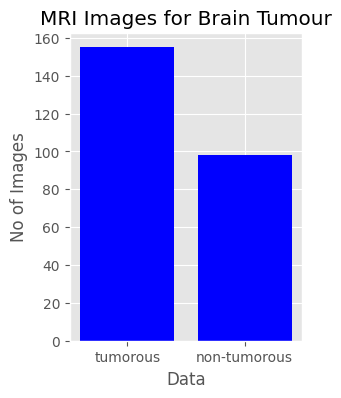

In [5]:
data = {'tumorous' : number_files_yes, 'non-tumorous' : number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(3,4))

plt.bar(typex, values, color='blue')

plt.xlabel("Data")
plt.ylabel("No of Images")
plt.title("MRI Images for Brain Tumour")
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [7]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [8]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        
        for batch in data_gen.flow(x = image, batch_size =1, save_to_dir = save_to_dir, save_prefix=save_prefix, save_format='jpg'):
            i+=1
            if i>n_generated_samples:
                break
        


    

In [9]:
import time
start_time = time.time()
print("Start:", timing(start_time))

yes_path = 'brain_tumor_dataset/yes'
no_path =  'brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples= 6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples= 9, save_to_dir=augmented_data_path+'no')

end_time= time.time()
execution_time = end_time- start_time
print("Total Time:", timing(execution_time))



Start: 476885:37:22.144158124923706
Total Time: 0:1:46.02151536941528


In [10]:
def data_summary(main_path):
    yes_path = 'augmented_data/yes'
    no_path = 'augmented_data/no'

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = n_neg + n_pos
    
    pos_per = (n_pos/n)*100
    neg_per = (n_neg/n)*100

    print(f"No of Samples: {n}")
    print(f"Percentage -> Positive: {pos_per} %, Negative: {neg_per} %")

In [11]:
data_summary(augmented_data)

No of Samples: 2062
Percentage -> Positive: 52.521823472356935 %, Negative: 47.478176527643065 %


In [12]:
listyes = os.listdir("augmented_data/yes/")
number_augmented_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_augmented_files_no = len(listno)
print(number_files_no)

155
98


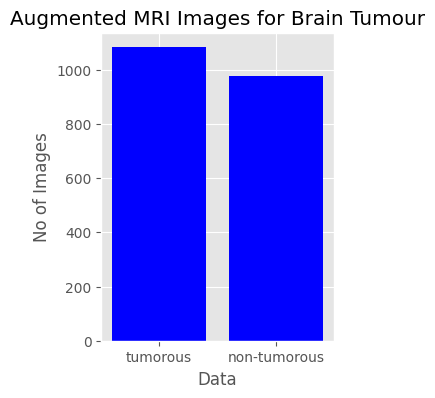

In [13]:
data = {'tumorous' : number_augmented_files_yes, 'non-tumorous' : number_augmented_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(3,4))

plt.bar(typex, values, color='blue')

plt.xlabel("Data")
plt.ylabel("No of Images")
plt.title("Augmented MRI Images for Brain Tumour")
plt.show()

In [54]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # plt.figure()
    # plt.imshow(gray, cmap='gray')
    # plt.title('Grayscale Image')
    # plt.show()
    
    gray = cv2.GaussianBlur(gray, (5,5), 1)
    # plt.figure()
    # plt.imshow(gray, cmap='gray')
    # plt.title('Blurred Image')
    # plt.show()

    thres= cv2.threshold(gray, 45, 455, cv2.THRESH_BINARY)[1]
    # plt.figure()
    # plt.imshow(thres, cmap='gray')
    # plt.title('Thresholded Image')
    # plt.show()
    
    thres= cv2.erode(thres, None, iterations =2)
    # plt.figure()
    # plt.imshow(thres, cmap='gray')
    # plt.title('Eroded Image')
    # plt.show()
    
    thres= cv2.dilate(thres, None, iterations =2)
    # plt.figure()
    # plt.imshow(thres, cmap='gray')
    # plt.title('Dilated Image')
    # plt.show()

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key= cv2.contourArea)

    # print(c)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title("Original Image")

        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title("Cropped Image")
        plt.show()

    return new_image    

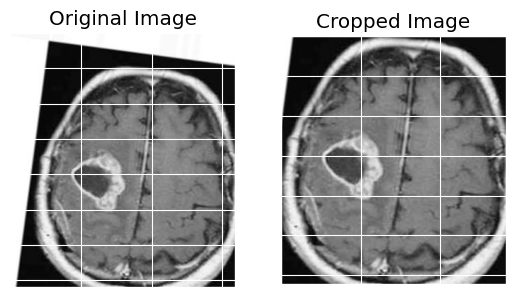

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 49,  49,  49],
        [ 60,  60,  60],
        [ 70,  70,  70]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 15,  15,  15],
        [ 16,  16,  16],
        [ 17,  17,  17]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 15,  15,  15],
        [ 14,  14,  14],
        [ 12,  12,  12]],

       ...,

       [[  8,   8,   8],
        [  8,   8,   8],
        [  8,   8,   8],
        ...,
        [ 12,  12,  12],
        [ 12,  12,  12],
        [ 12,  12,  12]],

       [[  9,   9,   9],
        [  9,   9,   9],
        [  9,   9,   9],
        ...,
        [ 12,  12,  12],
        [ 12,  12,  12],
        [ 12,  12,  12]],

       [[  8,   8,   8],
        [  8,   8,   8],
        [  8,   8,   8],
        ...,
        [ 12,  12,  12],
        [ 12,  12,  12],
        [ 12,  12,  12]]

In [55]:
img= cv2.imread('augmented_data/yes/aug_Y_3_0_5810.jpg')
crop_brain_tumor(img, True)

In [91]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [92]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image=crop_brain_tumor(image, plot =False)
            image=cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image= image/255.0
            X.append(image)
            if directory[-3:]=="yes":
                y.append(1)
            else:
                y.append(0)
    X= np.array(X)
    Y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Num of example: {len(X)}")
    print(f"X Shape is: {X.shape}")
    print(f"Y Shape is: {Y.shape}")

    return X,y
    

In [93]:
augmented_yes = 'augmented_data/yes'
augmented_no = 'augmented_data/no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)


X,y = load_data([augmented_yes, augmented_no], (IMAGE_WIDTH, IMAGE_HEIGHT))


Num of example: 2062
X Shape is: (2062, 240, 240, 3)
Y Shape is: (2062,)


In [106]:
files= os.listdir('augmented_data/yes')
fnames=[]
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join('augmented_data/yes', fname)
    dst=os.path.join('tumorous_and_nontumorous/train/tumorous', fname)
    shutil.copyfile(src,dst)

In [107]:
files= os.listdir('augmented_data/yes')
fnames=[]
for i in range(759, 922):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join('augmented_data/yes', fname)
    dst=os.path.join('tumorous_and_nontumorous/test/tumorous', fname)
    shutil.copyfile(src,dst)

In [110]:
files= os.listdir('augmented_data/yes')
fnames=[]
for i in range(922,1083):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join('augmented_data/yes', fname)
    dst=os.path.join('tumorous_and_nontumorous/valid/tumorous', fname)
    shutil.copyfile(src,dst)

In [111]:
files= os.listdir('augmented_data/no')
fnames=[]
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join('augmented_data/no', fname)
    dst=os.path.join('tumorous_and_nontumorous/train/nontumorous', fname)
    shutil.copyfile(src,dst)

In [112]:
files= os.listdir('augmented_data/no')
fnames=[]
for i in range(0,683):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join('augmented_data/no', fname)
    dst=os.path.join('tumorous_and_nontumorous/train/nontumorous', fname)
    shutil.copyfile(src,dst)

In [113]:
files= os.listdir('augmented_data/no')
fnames=[]
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join('augmented_data/no', fname)
    dst=os.path.join('tumorous_and_nontumorous/test/nontumorous', fname)
    shutil.copyfile(src,dst)

In [114]:
files= os.listdir('augmented_data/no')
fnames=[]
for i in range(686,979):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join('augmented_data/no', fname)
    dst=os.path.join('tumorous_and_nontumorous/valid/nontumorous', fname)
    shutil.copyfile(src,dst)

In [117]:
train_datagen = ImageDataGenerator(rescale=1./255,
                   horizontal_flip=0.4,
                   vertical_flip=0.4,
                   rotation_range=40,
                   shear_range=0.2,
                   width_shift_range=0.4,
                   height_shift_range=0.4,
                   fill_mode='nearest'
                  )

test_data_gen = ImageDataGenerator(rescale=1/255)
valid_data_gen = ImageDataGenerator(rescale=1/255)

In [118]:
train_generator= train_datagen.flow_from_directory('tumorous_and_nontumorous/train', batch_size=32, target_size=(240,240), class_mode='categorical', shuffle='True', seed=42, color_mode='rgb')

Found 1442 images belonging to 2 classes.


In [122]:
test_generator = test_data_gen.flow_from_directory('tumorous_and_nontumorous/test', batch_size=32, target_size=(240,240), class_mode='categorical', shuffle='True', seed=42, color_mode='rgb')

Found 310 images belonging to 2 classes.


In [123]:
valid_generator = valid_data_gen.flow_from_directory('tumorous_and_nontumorous/valid', batch_size=32, target_size=(240,240), class_mode='categorical', shuffle='True', seed=42, color_mode='rgb')

Found 454 images belonging to 2 classes.


In [130]:
class_labels = train_generator.class_indices
class_name= {value: key for (key,value) in class_labels.items()}

In [131]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [142]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights= 'imagenet')

for layer in base_model.layers:
    layer.trainable= False

x=base_model.output
flat= Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [139]:
# callback
filepath = 'model.keras'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [146]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum= 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

In [148]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs=2, callbacks=[es,cp,lrr], validation_data=[valid_generator])

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5320 - loss: 0.7140
Epoch 1: val_loss improved from 0.87899 to 0.69340, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 190s 20s/step - accuracy: 0.5316 - loss: 0.7141 - val_accuracy: 0.5264 - val_loss: 0.6934 - learning_rate: 1.0000e-04
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6017 - loss: 0.6843
Epoch 2: val_loss did not improve from 0.69340
10/10 ━━━━━━━━━━━━━━━━━━━━ 198s 21s/step - accuracy: 0.5998 - loss: 0.6845 - val_accuracy: 0.4692 - val_loss: 0.7296 - learning_rate: 1.0000e-04


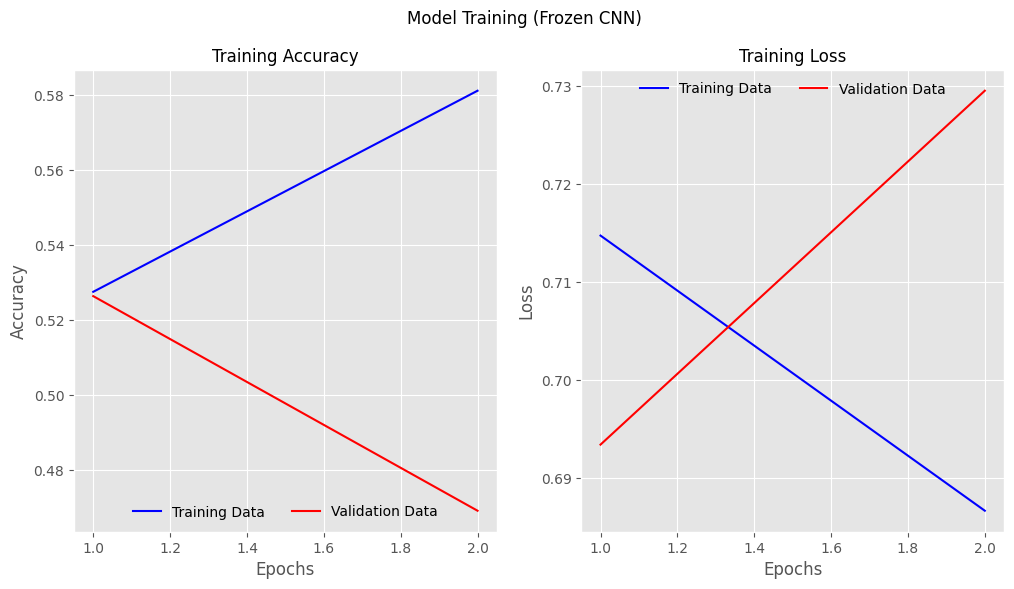

In [151]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [153]:
model_01.save_weights(filepath='model_weights/vgg19_model_01.weights.h5', overwrite=True)

In [155]:
model_01.load_weights("model_weights/vgg19_model_01.weights.h5")
vgg_val_eval_01= model_01.evaluate(valid_generator)
vgg_test_eval_01= model_01.evaluate(test_generator)

15/15 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.4857 - loss: 0.7172


C:\Users\nitis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.5169 - loss: 0.7067


In [156]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.7295535802841187
Validation Acc: 0.4691630005836487
Testing Loss: 0.7039615511894226
Testing Acc: 0.5258064270019531


In [ ]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

In [ ]:
b